Encontradas 14 imagens para processar

Processando: data_tiles/img (1).jpg

Processando: data_tiles/img (3).jpg

Processando: data_tiles/img (2).jpg

Processando: data_tiles/img (10).jpg

Processando: data_tiles/img (11).jpg

Processando: data_tiles/img (3).jpeg

Processando: data_tiles/img (9).jpeg

Processando: data_tiles/img (2).jpeg

Processando: data_tiles/img (8).jpeg

Processando: data_tiles/img (6).jpeg

Processando: data_tiles/img (1).jpeg

Processando: data_tiles/img (4).jpeg

Processando: data_tiles/img (7).jpeg

Processando: data_tiles/img (5).jpeg


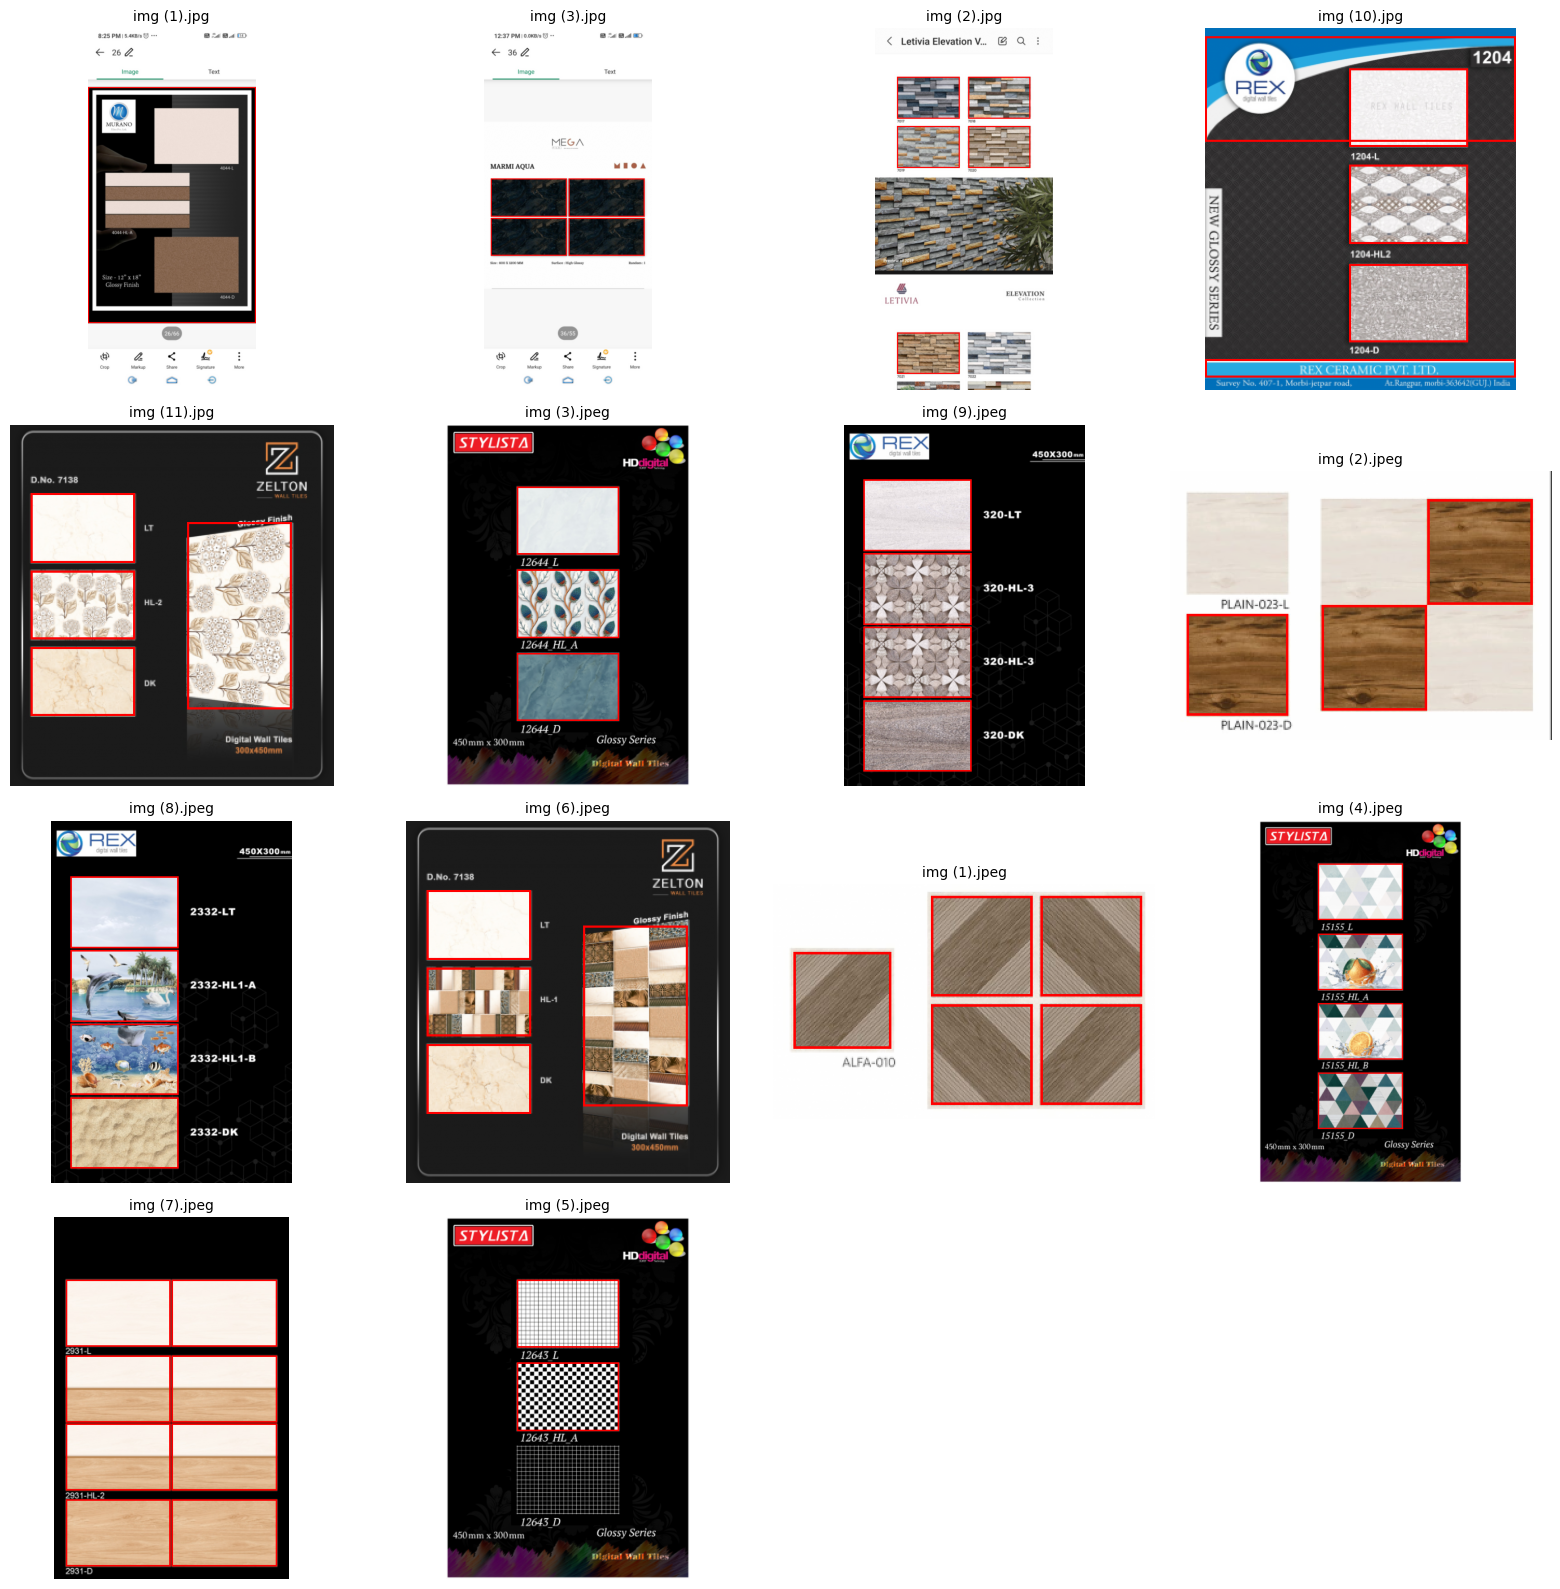

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, measure
from skimage.transform import resize as sk_resize
from skimage.util import invert as sk_invert
from scipy import ndimage
import os
import glob
import math

# Pasta das imagens
train_folder = "data_tiles"

# Obter lista de todas as imagens na pasta train
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
image_files = []
for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(train_folder, ext)))
    image_files.extend(glob.glob(os.path.join(train_folder, ext.upper())))

print(f"Encontradas {len(image_files)} imagens para processar")

# Cria a pasta 'txt' se ela não existir
output_folder = "txt"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Lista para armazenar as imagens processadas
processed_images = []
image_names = []

# Loop para processar cada imagem
for image_path in image_files:
    print(f"\nProcessando: {image_path}")

    try:
        original_image = io.imread(image_path)

        original_height, original_width = original_image.shape[:2]
        new_width = 300
        scale = new_width / original_width
        new_height = int(original_height * scale)

        resized_image = sk_resize(original_image, (new_height, new_width), anti_aliasing=True)

        gray_image = color.rgb2gray(resized_image)

        otsu_threshold = filters.threshold_otsu(gray_image)
        binary_image = gray_image < otsu_threshold

        border_check_width = 5
        dark_threshold = 0.5

        top_border = binary_image[:border_check_width, :] 
        bottom_border = binary_image[-border_check_width:, :] 
        left_border = binary_image[:, :border_check_width] 
        right_border = binary_image[:, -border_check_width:] 

        concatenated_borders = np.concatenate((top_border, bottom_border, left_border, right_border), axis=None)
        dark_pixel_proportion = np.sum(concatenated_borders < dark_threshold) / concatenated_borders.size

        processed_image = binary_image if dark_pixel_proportion > 0.5 else sk_invert(binary_image)

        labeled_image, num_regions = ndimage.label(processed_image)

        found_regions = measure.regionprops(labeled_image)
        valid_mask = np.zeros_like(labeled_image, dtype=bool)

        for reg in found_regions:
            if 4000 <= reg.area <= 45000:
                valid_mask[labeled_image == reg.label] = True

        filtered_image = labeled_image * valid_mask

        image_with_boxes = resized_image.copy()
        if image_with_boxes.dtype != float:
            image_with_boxes = image_with_boxes / 255.0

        border_color = (1, 0, 0)
        border_thickness = 2

        valid_labels = np.unique(filtered_image)
        valid_labels = valid_labels[valid_labels != 0]

        for r in valid_labels:
            coordinates = np.column_stack(np.where(filtered_image == r))
            min_row, min_col = coordinates.min(axis=0)
            max_row, max_col = coordinates.max(axis=0)

            for w in range(border_thickness):
                if min_row + w < image_with_boxes.shape[0]: 
                    image_with_boxes[min_row + w, min_col:max_col+1] = border_color
                if max_row - w >= 0: 
                    image_with_boxes[max_row - w, min_col:max_col+1] = border_color
                if min_col + w < image_with_boxes.shape[1]: 
                    image_with_boxes[min_row:max_row+1, min_col + w] = border_color
                if max_col - w >= 0: 
                    image_with_boxes[min_row:max_row+1, max_col - w] = border_color

        processed_images.append(image_with_boxes)
        image_names.append(os.path.basename(image_path))

        image_height, image_width = resized_image.shape[:2]

    except Exception as e:
        print(f"Erro ao processar {image_path}: {e}")
        continue

if processed_images:
    num_images = len(processed_images)
    cols = math.ceil(math.sqrt(num_images))
    rows = math.ceil(num_images / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    
    if num_images == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for i, (img, name) in enumerate(zip(processed_images, image_names)):
        axes_flat[i].imshow(img)
        axes_flat[i].set_title(name, fontsize=10)
        axes_flat[i].axis('off')
    
    for i in range(num_images, len(axes_flat)):
        axes_flat[i].remove()
    
    plt.tight_layout()
    plt.show()